 1. Маппинг unified_id
 2. Загрузка датасетов из открытых источников
 3. Попытка сметчить каталог и открытые данные
 4. Отбор айдишников из каталога, которые имеются в candidates

In [1]:
import msgpack
import boto3
import awswrangler as wr
from io import BytesIO
import pickle
import numpy as np
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import json

np.random.seed(1)

In [2]:
import matplotlib
matplotlib.__version__

'3.5.2'

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Connection

In [4]:
ACCESS_KEY='du3wAsX0uzEBBn4AdkFpCX4ZTXvSWFVG48GA4jbT'
SECRET_KEY='WA0NJOX0AFAY4K1J92XZ'

wr.config.s3_endpoint_url = 'https://obs.ru-moscow-1.hc.sbercloud.ru'

boto3.setup_default_session(
    region_name='ru-moscow',
    aws_access_key_id=SECRET_KEY,
    aws_secret_access_key=ACCESS_KEY,
)

def _get_default_boto3_client():
    return boto3.client('s3', endpoint_url=wr.config.s3_endpoint_url)

def get_object(s3_url):
    s3_client = _get_default_boto3_client()
    bucket, key = _split_3s_url_to_bucket_and_key(s3_url)
    return s3_client.get_object(Bucket=bucket, Key=key)




# Kinopoisk features

In [5]:
kp_path = 's3://ml-okko-object-storage/cold_start/data.json'
kp_df = wr.s3.read_json(kp_path).T

In [9]:
kp_df.shape

(10917, 47)

In [8]:
kp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10917 entries, e785baa6-f175-42b4-9e16-4319ac7991d5 to 6dd86e60-5d6d-475d-9b46-e989ac7a30b6
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   kinopoisk_id                    10917 non-null  object
 1   imdb_id                         8352 non-null   object
 2   name_ru                         10868 non-null  object
 3   name_en                         0 non-null      object
 4   name_original                   8239 non-null   object
 5   poster_url                      10917 non-null  object
 6   poster_url_preview              10917 non-null  object
 7   reviews_count                   10917 non-null  object
 8   rating_good_review              7915 non-null   object
 9   rating_good_review_vote_count   10917 non-null  object
 10  rating_kinopoisk                9999 non-null   object
 11  rating_kinopoisk_vote_count     10917 non-nul

In [7]:
kp_df.head(1).T

,e785baa6-f175-42b4-9e16-4319ac7991d5
kinopoisk_id,6580
imdb_id,tt0098382
name_ru,Звездный путь 5: Последний рубеж
name_en,None
name_original,Star Trek V: The Final Frontier
poster_url,https://kinopoiskapiunofficial.tech/images/pos...
poster_url_preview,https://kinopoiskapiunofficial.tech/images/pos...
reviews_count,12
rating_good_review,58.3
rating_good_review_vote_count,5


In [14]:
kp_df['poster_url'][1]

'https://kinopoiskapiunofficial.tech/images/posters/kp/6460.jpg'

In [15]:
kp_df['poster_url_preview'][1]

'https://kinopoiskapiunofficial.tech/images/posters/kp_small/6460.jpg'

In [118]:
kp_df.head(1)['box_office'].values

array([list([{'type': 'BUDGET', 'amount': 27800000, 'currency_code': 'USD', 'name': 'US Dollar', 'symbol': '$'}, {'type': 'USA', 'amount': 52210049, 'currency_code': 'USD', 'name': 'US Dollar', 'symbol': '$'}, {'type': 'WORLD', 'amount': 52210049, 'currency_code': 'USD', 'name': 'US Dollar', 'symbol': '$'}])],
      dtype=object)

In [119]:
kp_df.head(1)['distributions'].values

array([list([{'type': 'PREMIERE', 'sub_type': None, 'date': '1989-06-09T00:00:00', 're_release': False, 'country': 'США', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-06-24T00:00:00', 're_release': False, 'country': 'Япония', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-08-15T00:00:00', 're_release': False, 'country': 'Колумбия', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-06T00:00:00', 're_release': False, 'country': 'Бразилия', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-12T00:00:00', 're_release': False, 'country': 'Аргентина', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-20T00:00:00', 're_release': False, 'country': 'Ирландия', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-10-20T00:00:00', 're_release': False, 'country': 'Великобритания', 'companies': []}, {'type': 'PREMIERE', 'sub_type': None, 'date': '1989-11-09T00:0

In [120]:
kp_df.head(1)['staff'].values[0]

[{'staff_id': 3024,
  'name_ru': 'Уильям Шетнер',
  'name_en': 'William Shatner',
  'description': None,
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/3024.jpg',
  'profession_text': 'Режиссеры',
  'profession_key': 'DIRECTOR'},
 {'staff_id': 3024,
  'name_ru': 'Уильям Шетнер',
  'name_en': 'William Shatner',
  'description': 'Kirk',
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/3024.jpg',
  'profession_text': 'Актеры',
  'profession_key': 'ACTOR'},
 {'staff_id': 187,
  'name_ru': 'Леонард Нимой',
  'name_en': 'Leonard Nimoy',
  'description': 'Spock',
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/187.jpg',
  'profession_text': 'Актеры',
  'profession_key': 'ACTOR'},
 {'staff_id': 78580,
  'name_ru': 'ДеФорест Келли',
  'name_en': 'DeForest Kelley',
  'description': 'McCoy',
  'poster_url': 'https://kinopoiskapiunofficial.tech/images/actor_posters/kp/78580.jpg',
  'profession_text': 'Актеры',
 

## EDA

In [121]:
# nans
kp_df.isnull().sum()

kinopoisk_id                          0
imdb_id                            2565
name_ru                              49
name_en                           10917
name_original                      2678
poster_url                            0
poster_url_preview                    0
reviews_count                         0
rating_good_review                 3002
rating_good_review_vote_count         0
rating_kinopoisk                    918
rating_kinopoisk_vote_count           0
rating_imdb                        1249
rating_imdb_vote_count                0
rating_film_critics                6334
rating_film_critics_vote_count        0
rating_await                       7772
rating_await_count                    0
rating_rf_critics                  9067
rating_rf_critics_vote_count          0
year                                  1
film_length                        2371
is_tickets_available                  0
production_status                 10913
type                                  0


In [122]:
kp_df.shape

(10917, 47)

## Parse staff

In [123]:
import pandas as pd

In [124]:
unique_roles = []
for staff in kp_df['staff'].values:
    if staff:
        for member in staff:
            unique_roles.append(member['profession_key'])

In [125]:
pd.Series(unique_roles).value_counts()

ACTOR             657697
PRODUCER           84587
WRITER             38025
DESIGN             37742
DIRECTOR           21243
EDITOR             15862
OPERATOR           12489
COMPOSER           12484
VOICE_DIRECTOR      3949
TRANSLATOR          2067
PRODUCER_USSR        659
dtype: int64

In [126]:
# parse cast to dataframe
roles = ['ACTOR',
         'COMPOSER',
         'DESIGN',
         'DIRECTOR',
         'EDITOR',
         'OPERATOR',
         'PRODUCER',
         'WRITER']

staff_df = pd.DataFrame()

for staff in kp_df['staff']:
    cast = {role: [[]] for role in roles}
    if staff:
        for member in staff:
            if member['profession_key'] in roles and member['name_ru'] != '' :
                cast[member['profession_key']][0].append(member['name_ru'])
    cast = {role: (names if names != [[]] else [np.nan]) for role, names in cast.items()}

    staff_df = pd.concat([staff_df, pd.DataFrame.from_dict(cast)])

staff_df.index = kp_df.index

In [127]:
staff_df.isnull().sum()

ACTOR        225
COMPOSER    1447
DESIGN      1530
DIRECTOR     161
EDITOR      1986
OPERATOR    1512
PRODUCER    1296
WRITER       363
dtype: int64

In [128]:
staff_df.head()

,ACTOR,COMPOSER,DESIGN,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER
e785baa6-f175-42b4-9e16-4319ac7991d5,"[Уильям Шетнер, Леонард Нимой, ДеФорест Келли,...","[Джерри Голдсмит, Хиросима]","[Херман Ф. Зиммерман, Нило Родис-Джамеро, Джон...",[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет..."
4593737e-de9c-40df-97db-fb3cf85a08ef,"[Уильям Шетнер, Леонард Нимой, ДеФорест Келли,...",[Клифф Эйдельман],"[Херман Ф. Зиммерман, Нило Родис-Джамеро, Доди...",[Николас Мейер],"[Уильям Хой, Рональд Руз]",[Хиро Нарита],"[Стивен-Чарльз Джаффе, Ральф Уинтер, Брук Брет...","[Джин Родденберри, Леонард Нимой, Лоуренс Конн..."
11ba66db-e941-4c3a-8da6-d8900e56f8c7,"[Уильям Шетнер, Джери Райан, Джейсон Брукс, Ро...",NaN,"[Линдсей Моремен, Нина Чермак Розенберг]",[Джаред Кон],NaN,NaN,"[Джаред Кон, Майкл Мейландер, Брайан Перера]",[Морис Хёрли]
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,"[Чарли Шин, Сет МакФарлейн, Майк Тайсон, Кейт ...",NaN,"[Джон Кэлкинс, Ричард Шрайбер]",[Джоэл Галлен],NaN,NaN,"[Рик Остин, Марк Бёрг, Роб Кроуфорд, Джоэл Гал...","[Рэй Джеймс, Майкл Ферруччи, Крис МакГуайр, Фр..."
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,"[Уильям Шетнер, Джейсон Александер, Фарра Фосе...",NaN,"[Джон Кэлкинс, Паула Элинс]",[Джоэл Галлен],"[Билл ДеРонде, Наруми Инацугу]",NaN,"[Рик Остин, Роб Кроуфорд, Джоэл Галлен, Мишель...","[Майкл Ферруччи, Мэтью Харауиц, Джо Келли, Аар..."


## Parse box office 

In [129]:
kp_df['box_office'].values[1]

[{'type': 'BUDGET',
  'amount': 30000000,
  'currency_code': 'USD',
  'name': 'US Dollar',
  'symbol': '$'},
 {'type': 'WORLD',
  'amount': 96888996,
  'currency_code': 'USD',
  'name': 'US Dollar',
  'symbol': '$'},
 {'type': 'USA',
  'amount': 74888996,
  'currency_code': 'USD',
  'name': 'US Dollar',
  'symbol': '$'}]

In [130]:
unique_box_offices_types = []
for box in kp_df['box_office'].values:
    if box:
        for source in box:
            unique_box_offices_types.append(source['type'])

In [131]:
pd.Series(unique_box_offices_types).value_counts()

WORLD        5370
BUDGET       3834
RUS          3698
USA          3677
MARKETING     262
dtype: int64

In [132]:
set(unique_box_offices_types)

{'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD'}

In [133]:
currencies = []
for box in kp_df['box_office'].values:
    if box:
        for source in box:
            currencies.append(source['currency_code'])

In [134]:
pd.Series(currencies).value_counts()

USD    16163
EUR      230
         166
RUB      112
GBP       53
CAD       17
RUR       14
FRF       13
AUD       12
NOK       10
DKK        8
SEK        7
JPY        4
HKD        4
CNY        4
INR        3
DEM        3
MXN        3
THB        2
BRL        2
NZD        2
PLN        2
KRW        2
UAH        1
HUF        1
FIM        1
CHF        1
CZK        1
dtype: int64

In [135]:
# parse cast to dataframe
box_offices = ['BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']

bo_df = pd.DataFrame()

for income in kp_df['box_office']:
    sources = {source: [np.nan] for source in box_offices}
    if income:
        for source in income:
            if source['currency_code'] == 'USD':
                sources[source['type']][0] = source['amount']
    bo_df = pd.concat([bo_df, pd.DataFrame.from_dict(sources)])

bo_df.index = kp_df.index

In [136]:
bo_df.isnull().sum()

BUDGET        7603
MARKETING    10663
RUS           7285
USA           7260
WORLD         5611
dtype: int64

In [137]:
bo_df

,BUDGET,MARKETING,RUS,USA,WORLD
e785baa6-f175-42b4-9e16-4319ac7991d5,27800000.0,NaN,NaN,52210049.0,52210049.0
4593737e-de9c-40df-97db-fb3cf85a08ef,30000000.0,NaN,NaN,74888996.0,96888996.0
11ba66db-e941-4c3a-8da6-d8900e56f8c7,NaN,NaN,NaN,NaN,NaN
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,NaN,NaN,NaN,NaN,NaN
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
43bddcc0-db12-428e-9c65-f5606aa4b989,NaN,NaN,NaN,NaN,NaN
ac0c9152-c070-43a0-bb99-7e72764b7c0a,NaN,NaN,NaN,NaN,NaN
ce8d2906-a33f-4140-9ffe-e091990d71a4,30000000.0,NaN,1464252.0,28780744.0,59284015.0
0bfb5a13-50fc-48f3-b51a-a30971024651,NaN,NaN,NaN,NaN,NaN


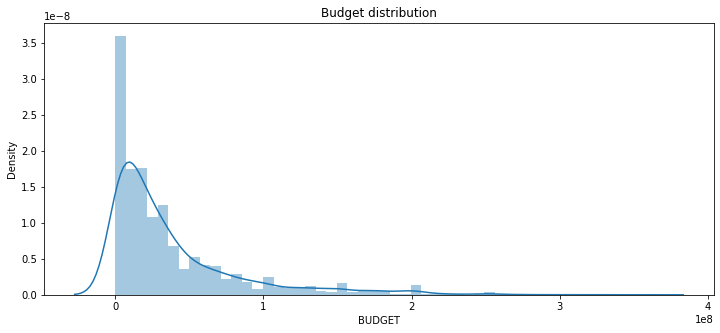

In [138]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['BUDGET'])
plt.title('Budget distribution')
plt.show()

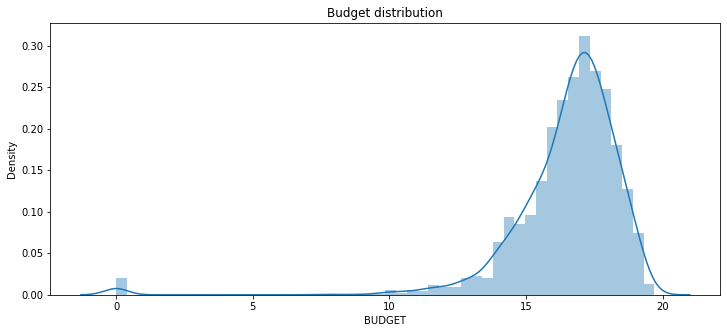

In [139]:
# log1p

plt.figure(figsize=(12, 5))
sns.distplot(np.log1p(bo_df['BUDGET']))
plt.title('Budget distribution')
plt.show()

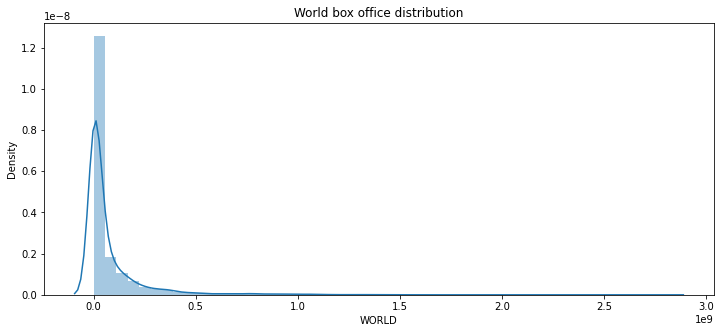

In [140]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['WORLD'])
plt.title('World box office distribution')
plt.show()

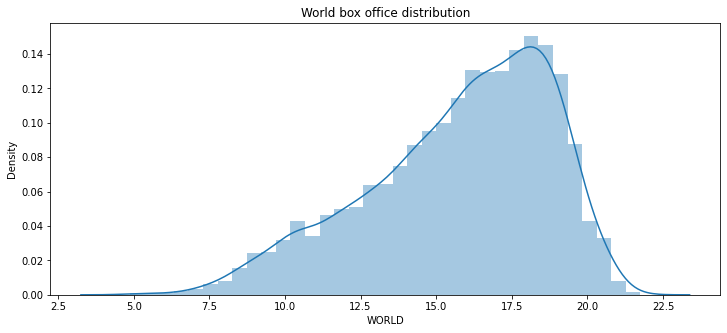

In [141]:
plt.figure(figsize=(12, 5))
sns.distplot(np.log1p(bo_df['WORLD']))
plt.title('World box office distribution')
plt.show()

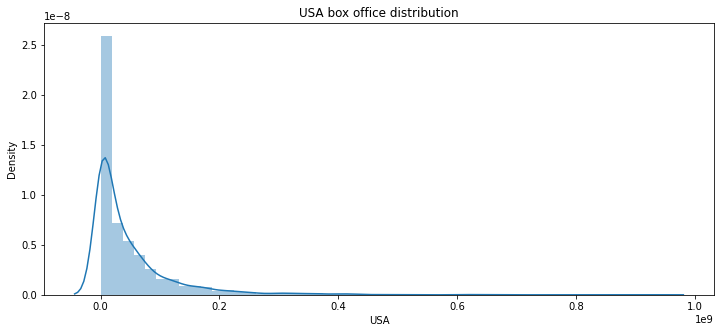

In [142]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['USA'])
plt.title('USA box office distribution')
plt.show()

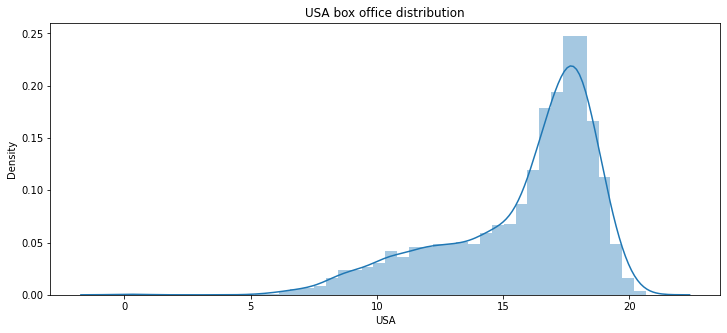

In [143]:
plt.figure(figsize=(12, 5))
sns.distplot(np.log1p(bo_df['USA']))
plt.title('USA box office distribution')
plt.show()

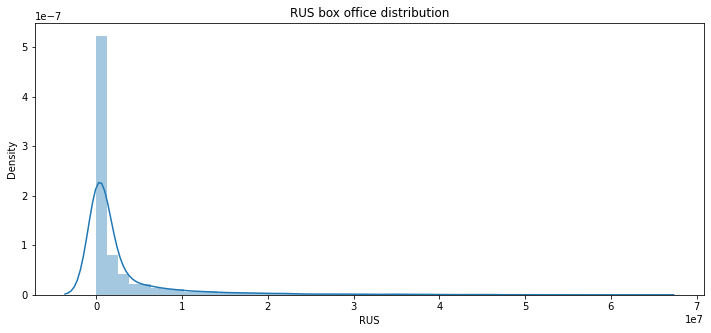

In [144]:
plt.figure(figsize=(12, 5))
sns.distplot(bo_df['RUS'])
plt.title('RUS box office distribution')
plt.show()

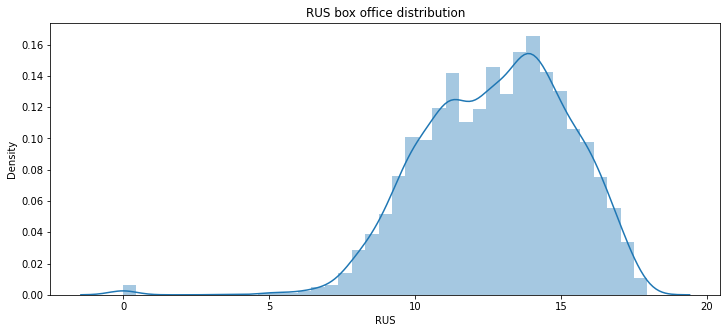

In [145]:
plt.figure(figsize=(12, 5))
sns.distplot(np.log1p(bo_df['RUS']))
plt.title('RUS box office distribution')
plt.show()

## Merging

In [146]:
df.shape

(38825, 17)

In [147]:
staff_df['uid'] = staff_df.index
bo_df['uid'] = bo_df.index

In [148]:
bo_df

,BUDGET,MARKETING,RUS,USA,WORLD,uid
e785baa6-f175-42b4-9e16-4319ac7991d5,27800000.0,NaN,NaN,52210049.0,52210049.0,e785baa6-f175-42b4-9e16-4319ac7991d5
4593737e-de9c-40df-97db-fb3cf85a08ef,30000000.0,NaN,NaN,74888996.0,96888996.0,4593737e-de9c-40df-97db-fb3cf85a08ef
11ba66db-e941-4c3a-8da6-d8900e56f8c7,NaN,NaN,NaN,NaN,NaN,11ba66db-e941-4c3a-8da6-d8900e56f8c7
3f30a2ef-53b7-40e3-954f-1bdfc38a6d17,NaN,NaN,NaN,NaN,NaN,3f30a2ef-53b7-40e3-954f-1bdfc38a6d17
cdfa700f-122d-41e5-b8dc-9c6813bab6d2,NaN,NaN,NaN,NaN,NaN,cdfa700f-122d-41e5-b8dc-9c6813bab6d2
...,...,...,...,...,...,...
43bddcc0-db12-428e-9c65-f5606aa4b989,NaN,NaN,NaN,NaN,NaN,43bddcc0-db12-428e-9c65-f5606aa4b989
ac0c9152-c070-43a0-bb99-7e72764b7c0a,NaN,NaN,NaN,NaN,NaN,ac0c9152-c070-43a0-bb99-7e72764b7c0a
ce8d2906-a33f-4140-9ffe-e091990d71a4,30000000.0,NaN,1464252.0,28780744.0,59284015.0,ce8d2906-a33f-4140-9ffe-e091990d71a4
0bfb5a13-50fc-48f3-b51a-a30971024651,NaN,NaN,NaN,NaN,NaN,0bfb5a13-50fc-48f3-b51a-a30971024651


In [149]:
df['uid'] = df.index
df['element_uid'] = df.index

In [150]:
df_merged = df.merge(staff_df,
                       on='uid',
                        how='inner').merge(bo_df,
                                           on='uid',
                                            how='inner')

In [151]:
df_merged.shape

(10917, 31)

In [152]:
df_merged.columns

Index(['age_access_type', 'name', 'availability', 'director', 'alias', 'genre',
       'average_rating', 'subscription_only', 'type', 'sale_start_date',
       'digital_uid', 'country', 'release_type', 'uid', 'release_year',
       'duration', 'actor', 'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN',
       'DIRECTOR', 'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET',
       'MARKETING', 'RUS', 'USA', 'WORLD'],
      dtype='object')

In [153]:
features = ['age_access_type', 'name',  'director', 'genre',
       'average_rating',  'type',  'country', 'release_type',  'release_year',
       'duration', 'actor', 'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN',
       'DIRECTOR', 'EDITOR', 'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET',
       'MARKETING', 'RUS', 'USA', 'WORLD']

In [154]:
df_merged = df_merged[features]

In [155]:
df_merged

,age_access_type,name,director,genre,average_rating,type,country,release_type,release_year,duration,...,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER,BUDGET,MARKETING,RUS,USA,WORLD
0,12,Звёздный путь 5: Последний рубеж,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],"[Sci-Fi, Action, Thriller, Adventure]",6.21,MOVIE,[usa],RELEASE,1989,6420000,...,[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет...",27800000.0,NaN,NaN,52210049.0,52210049.0
1,16,Звёздный путь 6: Неоткрытая страна,[bab6b7f4-4506-458f-9091-d567505674f2],"[Sci-Fi, Action, Thriller, Adventure]",7.2,MOVIE,[usa],RELEASE,1991,6780000,...,[Николас Мейер],"[Уильям Хой, Рональд Руз]",[Хиро Нарита],"[Стивен-Чарльз Джаффе, Ральф Уинтер, Брук Брет...","[Джин Родденберри, Леонард Нимой, Лоуренс Конн...",30000000.0,NaN,NaN,74888996.0,96888996.0
2,18,В поисках древнего артефакта,[895f5774-964a-4c5a-ae22-d697d3e3e620],[Horror],4.0,MOVIE,[usa],RELEASE,2019,6000000,...,[Джаред Кон],NaN,NaN,"[Джаред Кон, Майкл Мейландер, Брайан Перера]",[Морис Хёрли],NaN,NaN,NaN,NaN,NaN
3,18,Прожарка Чарли Шина,[1de22aff-430e-4af9-bf1d-159dbf8e9269],"[Comedy, Documentary]",6.99,MOVIE,[usa],RELEASE,2011,3780000,...,[Джоэл Галлен],NaN,NaN,"[Рик Остин, Марк Бёрг, Роб Кроуфорд, Джоэл Гал...","[Рэй Джеймс, Майкл Ферруччи, Крис МакГуайр, Фр...",NaN,NaN,NaN,NaN,NaN
4,18,Прожарка Уильяма Шэтнера,[1de22aff-430e-4af9-bf1d-159dbf8e9269],[Comedy],6.0,MOVIE,[usa],RELEASE,2006,3780000,...,[Джоэл Галлен],"[Билл ДеРонде, Наруми Инацугу]",NaN,"[Рик Остин, Роб Кроуфорд, Джоэл Галлен, Мишель...","[Майкл Ферруччи, Мэтью Харауиц, Джо Келли, Аар...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10912,0,Загадки Русской истории,[384deeb0-ab24-4e3f-9744-1660b2ecaf67],"[Documentary, d7214feb-8c11-4aea-aabb-ac98a8d5...",NaN,SERIAL,[russia],RELEASE,2011,25140000,...,[Карен Адамян],NaN,"[Евгений Спешилов, Денис Смирнов]","[Михаил Погосов, Карен Адамян]",[Игорь Курукин],NaN,NaN,NaN,NaN,NaN
10913,0,Изобретая игры,[ecc88cca-7660-4d74-a0af-18ca7069a743],[287a1485-7a88-4c2f-bc94-ca418b6c47a1],NaN,SERIAL,[brasil],RELEASE,2019,5400000,...,[Педро де Лима Маркеш],[Педро де Лима Маркеш],NaN,"[Дэни Израэль, Вивиан Хугеро, Педро де Лима Ма...",[Вивиан Хугеро],NaN,NaN,NaN,NaN,NaN
10914,6,Большие игры,[ad784ddb-a602-4082-bf6f-f83ec5a96edf],"[ForKids, 1f22ccf1-288a-4e6e-b39a-7502799e7125]",NaN,SERIAL,[russia],RELEASE,2022,3600000,...,[Аарон Соркин],"[Алан Баумгартен, Эллиот Грэхэм, Джош Шеффер]",[Шарлотта Брюус Кристенсен],"[Орен Авив, Фелис Би, Стюарт М. Бессер, Адам Ф...","[Аарон Соркин, Молли Блум]",30000000.0,NaN,1464252.0,28780744.0,59284015.0
10915,0,Природный патруль,[9d6f5496-2d1b-4f21-a2d8-52b316295c4a],[287a1485-7a88-4c2f-bc94-ca418b6c47a1],NaN,SERIAL,[china],RELEASE,2021,40560000,...,[Су Юнцзюнь],NaN,NaN,[Ли Чжубин],"[Сы Лун, Цянь Чуаньмэй]",NaN,NaN,NaN,NaN,NaN


In [156]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10917 entries, 0 to 10916
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age_access_type  10917 non-null  object 
 1   name             10917 non-null  object 
 2   director         10914 non-null  object 
 3   genre            10917 non-null  object 
 4   average_rating   10406 non-null  object 
 5   type             10917 non-null  object 
 6   country          10917 non-null  object 
 7   release_type     10917 non-null  object 
 8   release_year     10917 non-null  object 
 9   duration         10917 non-null  object 
 10  actor            10917 non-null  object 
 11  element_uid      10917 non-null  object 
 12  ACTOR            10692 non-null  object 
 13  COMPOSER         9470 non-null   object 
 14  DESIGN           9387 non-null   object 
 15  DIRECTOR         10756 non-null  object 
 16  EDITOR           8931 non-null   object 
 17  OPERATOR    

In [157]:
df_merged.isna().sum()

age_access_type        0
name                   0
director               3
genre                  0
average_rating       511
type                   0
country                0
release_type           0
release_year           0
duration               0
actor                  0
element_uid            0
ACTOR                225
COMPOSER            1447
DESIGN              1530
DIRECTOR             161
EDITOR              1986
OPERATOR            1512
PRODUCER            1296
WRITER               363
BUDGET              7603
MARKETING          10663
RUS                 7285
USA                 7260
WORLD               5611
dtype: int64

In [158]:
df_merged['duration'] = df_merged['duration'].astype(float)
df_merged['release_year'] = df_merged['release_year'].astype(int)
df_merged['average_rating'] = df_merged['average_rating'].astype(float)

## Multivariate analysis

In [159]:
features

['age_access_type',
 'name',
 'director',
 'genre',
 'average_rating',
 'type',
 'country',
 'release_type',
 'release_year',
 'duration',
 'actor',
 'element_uid',
 'ACTOR',
 'COMPOSER',
 'DESIGN',
 'DIRECTOR',
 'EDITOR',
 'OPERATOR',
 'PRODUCER',
 'WRITER',
 'BUDGET',
 'MARKETING',
 'RUS',
 'USA',
 'WORLD']

<AxesSubplot:>

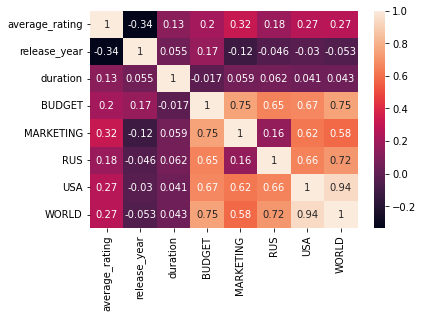

In [160]:
sns.heatmap(df_merged.corr(), annot=True)

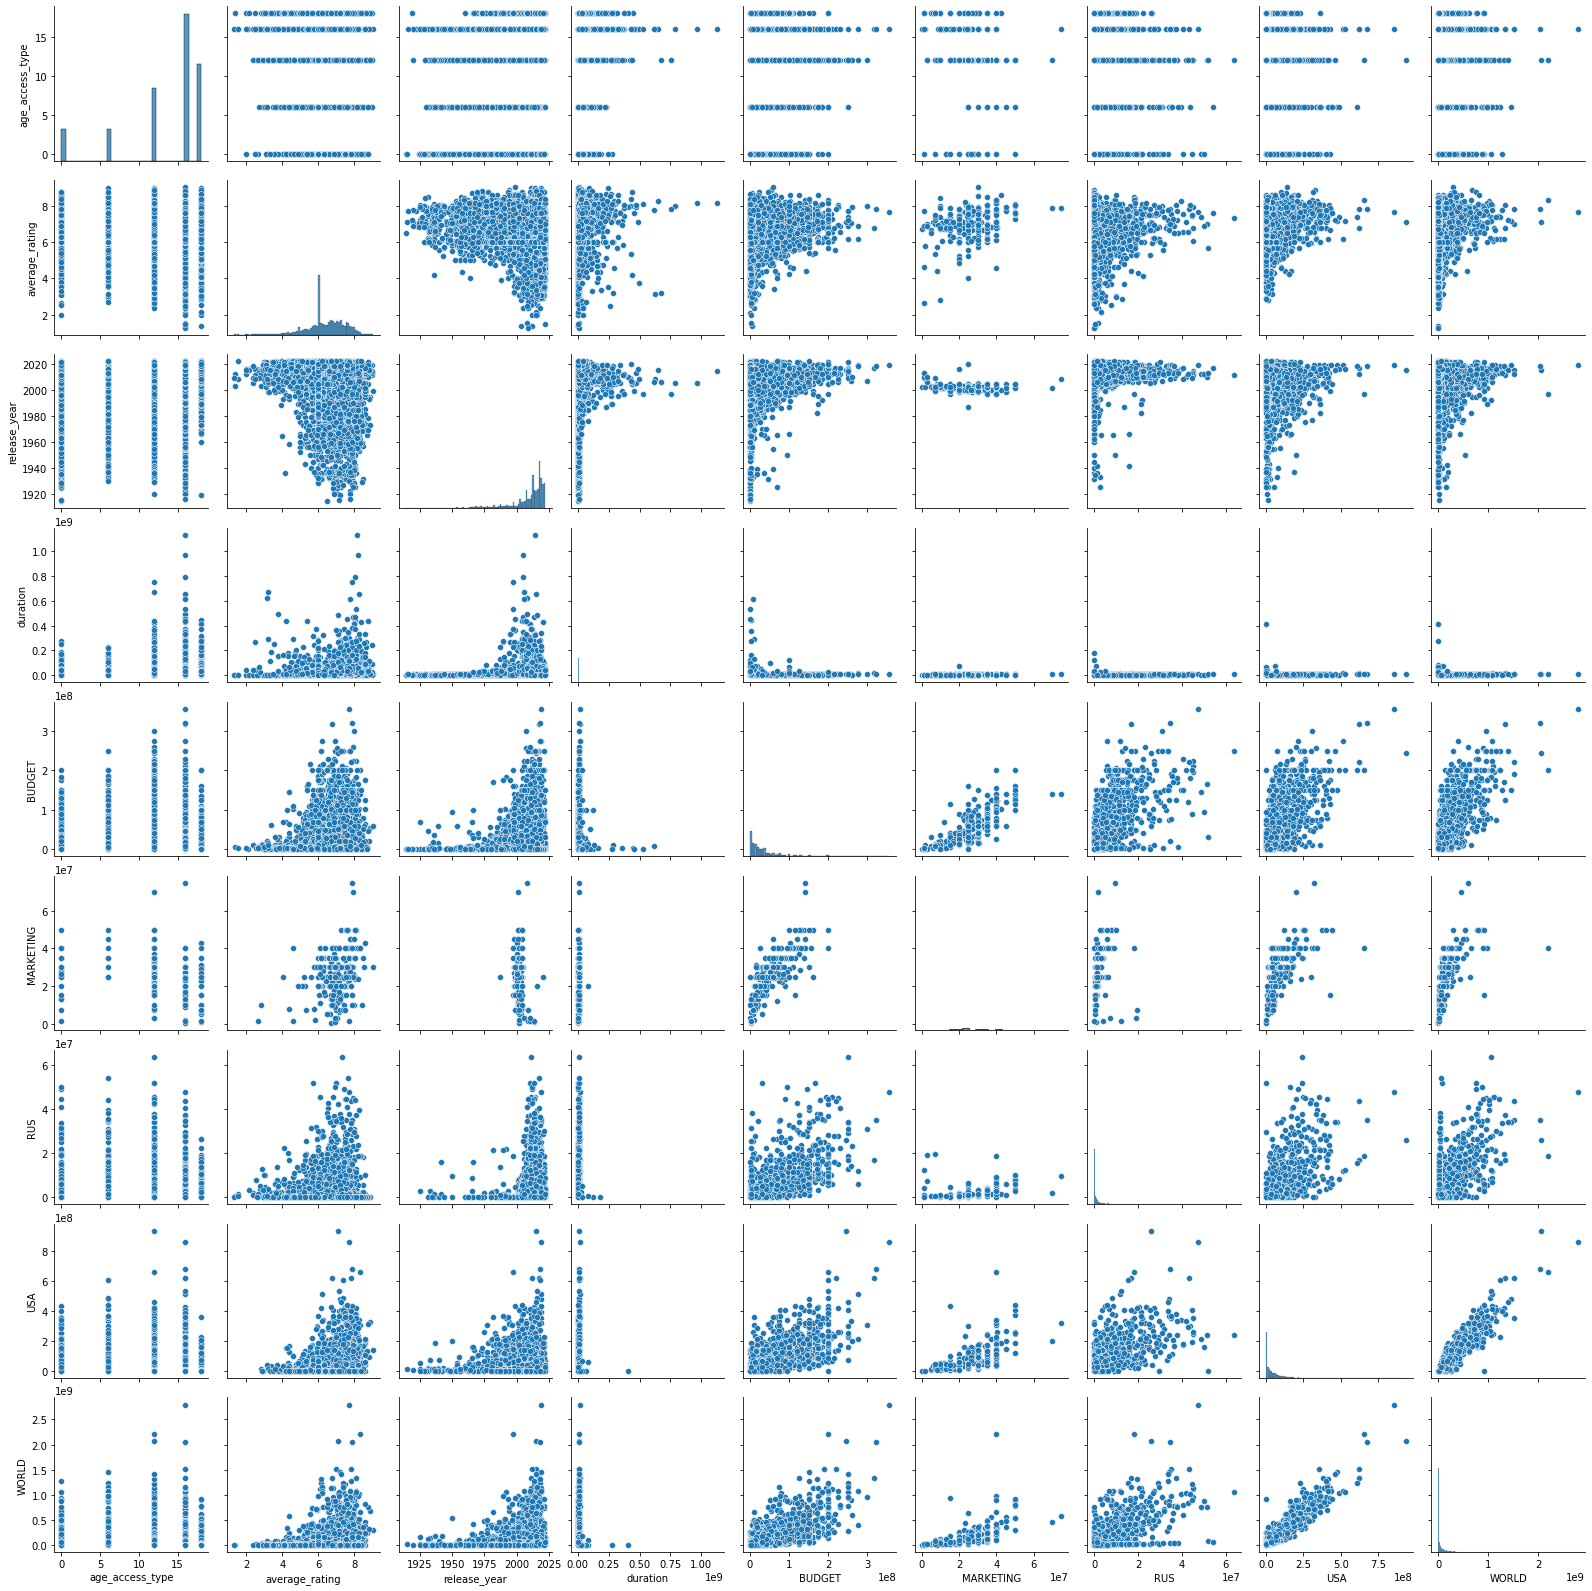

In [161]:
sns.pairplot(df_merged)
plt.show()

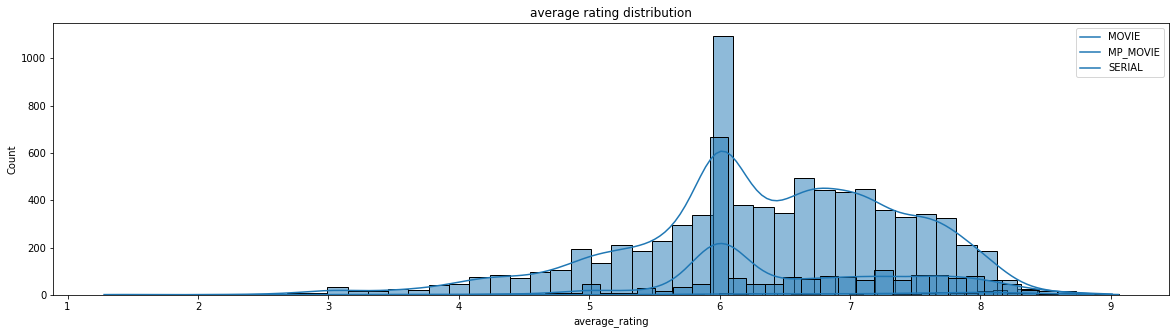

In [162]:
plt.figure(figsize=(20, 5))
for t in df_merged['type'].unique():
    sns.histplot(df_merged[df_merged['type'] == t]['average_rating'], bins=50, kde=True)
plt.legend(df_merged['type'].unique())
plt.title('average rating distribution')
plt.show()

In [163]:
df_merged

,age_access_type,name,director,genre,average_rating,type,country,release_type,release_year,duration,...,DIRECTOR,EDITOR,OPERATOR,PRODUCER,WRITER,BUDGET,MARKETING,RUS,USA,WORLD
0,12,Звёздный путь 5: Последний рубеж,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],"[Sci-Fi, Action, Thriller, Adventure]",6.21,MOVIE,[usa],RELEASE,1989,6420000.0,...,[Уильям Шетнер],[Питер Е. Бергер],[Эндрю Ласло],"[Харви Беннетт, Брук Бретон, Мэл Эфрос, Джин Р...","[Джин Родденберри, Уильям Шетнер, Харви Беннет...",27800000.0,NaN,NaN,52210049.0,52210049.0
1,16,Звёздный путь 6: Неоткрытая страна,[bab6b7f4-4506-458f-9091-d567505674f2],"[Sci-Fi, Action, Thriller, Adventure]",7.20,MOVIE,[usa],RELEASE,1991,6780000.0,...,[Николас Мейер],"[Уильям Хой, Рональд Руз]",[Хиро Нарита],"[Стивен-Чарльз Джаффе, Ральф Уинтер, Брук Брет...","[Джин Родденберри, Леонард Нимой, Лоуренс Конн...",30000000.0,NaN,NaN,74888996.0,96888996.0
2,18,В поисках древнего артефакта,[895f5774-964a-4c5a-ae22-d697d3e3e620],[Horror],4.00,MOVIE,[usa],RELEASE,2019,6000000.0,...,[Джаред Кон],NaN,NaN,"[Джаред Кон, Майкл Мейландер, Брайан Перера]",[Морис Хёрли],NaN,NaN,NaN,NaN,NaN
3,18,Прожарка Чарли Шина,[1de22aff-430e-4af9-bf1d-159dbf8e9269],"[Comedy, Documentary]",6.99,MOVIE,[usa],RELEASE,2011,3780000.0,...,[Джоэл Галлен],NaN,NaN,"[Рик Остин, Марк Бёрг, Роб Кроуфорд, Джоэл Гал...","[Рэй Джеймс, Майкл Ферруччи, Крис МакГуайр, Фр...",NaN,NaN,NaN,NaN,NaN
4,18,Прожарка Уильяма Шэтнера,[1de22aff-430e-4af9-bf1d-159dbf8e9269],[Comedy],6.00,MOVIE,[usa],RELEASE,2006,3780000.0,...,[Джоэл Галлен],"[Билл ДеРонде, Наруми Инацугу]",NaN,"[Рик Остин, Роб Кроуфорд, Джоэл Галлен, Мишель...","[Майкл Ферруччи, Мэтью Харауиц, Джо Келли, Аар...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10912,0,Загадки Русской истории,[384deeb0-ab24-4e3f-9744-1660b2ecaf67],"[Documentary, d7214feb-8c11-4aea-aabb-ac98a8d5...",NaN,SERIAL,[russia],RELEASE,2011,25140000.0,...,[Карен Адамян],NaN,"[Евгений Спешилов, Денис Смирнов]","[Михаил Погосов, Карен Адамян]",[Игорь Курукин],NaN,NaN,NaN,NaN,NaN
10913,0,Изобретая игры,[ecc88cca-7660-4d74-a0af-18ca7069a743],[287a1485-7a88-4c2f-bc94-ca418b6c47a1],NaN,SERIAL,[brasil],RELEASE,2019,5400000.0,...,[Педро де Лима Маркеш],[Педро де Лима Маркеш],NaN,"[Дэни Израэль, Вивиан Хугеро, Педро де Лима Ма...",[Вивиан Хугеро],NaN,NaN,NaN,NaN,NaN
10914,6,Большие игры,[ad784ddb-a602-4082-bf6f-f83ec5a96edf],"[ForKids, 1f22ccf1-288a-4e6e-b39a-7502799e7125]",NaN,SERIAL,[russia],RELEASE,2022,3600000.0,...,[Аарон Соркин],"[Алан Баумгартен, Эллиот Грэхэм, Джош Шеффер]",[Шарлотта Брюус Кристенсен],"[Орен Авив, Фелис Би, Стюарт М. Бессер, Адам Ф...","[Аарон Соркин, Молли Блум]",30000000.0,NaN,1464252.0,28780744.0,59284015.0
10915,0,Природный патруль,[9d6f5496-2d1b-4f21-a2d8-52b316295c4a],[287a1485-7a88-4c2f-bc94-ca418b6c47a1],NaN,SERIAL,[china],RELEASE,2021,40560000.0,...,[Су Юнцзюнь],NaN,NaN,[Ли Чжубин],"[Сы Лун, Цянь Чуаньмэй]",NaN,NaN,NaN,NaN,NaN


In [164]:
import pickle

with open('Kinop_ratings_parsed_data_added.pkl', 'wb') as f:
    pickle.dump(df_merged, f)

In [ ]:
# Think to get them late!!!!!

# reviews_count                         0
# rating_good_review_vote_count         0
# rating_kinopoisk                    918
# rating_imdb                        1249
# rating_imdb_vote_count                0
# has_imax                              0
# has_3_d                               0
# description                         255
# distributions                         0
# box_office                            0
# staff                                29
# countries                             0
# genres  